In [49]:
import pandas as pd 
import numpy as np 
from docplex.mp.model import Model

# -- INPUT DATA
P = [i for i in range(1,9)]
D = [i for i in range(9,17)]
N = P + D
V = [0] + P + D + [17]
Q = 15
L = 12
M = 9999
K = 5
df = pd.read_csv('dataset_vrppd.csv')
q = dict(zip(df.Node,df.Demand))
cx = df.coord_x.tolist()
cy = df.coord_y.tolist()
A = [(i,j) for i in V for j in V if i!=j]

s = dict(zip(df.Node,df.serv_time/60))

# arcs distance calculation

c = {(i,j): np.hypot(cx[i]-cx[j],cy[i]-cy[j]) for i in V for j in V if i!=j}

t = {(i,j): np.hypot(cx[i]-cx[j],cy[i]-cy[j])/60 for i in V for j in V if i!=j}

mdl = Model('cvrp')

# -- Variables

inter = [(i,j,k) for i,j in A  for k in range(K)]
list_for_varia = [(i,k) for i in V for k in range(K)]

x = mdl.binary_var_dict(inter,name = 'x')
C = mdl.continuous_var_dict(list_for_varia,name = 'C')
T = mdl.continuous_var_dict(list_for_varia,name = 'T')

# -- Objective Function 

mdl.minimize(mdl.sum(mdl.sum(t[(i,j)] * x[(i,j,k)] for i,j in A) for k in range(K)))

# -- CONSTRAINTS 

for i in P:
    mdl.add_constraint(mdl.sum(mdl.sum(x[(i,j,k)] for j in V[1:] if i!=j) for k in range(K)) == 1)
    
for k in range(K):
    for i in P:
        mdl.add_constraint(mdl.sum(x[(i,j,k)] for j in V[1:] if i != j) - mdl.sum(x[(8+i,j,k)] for j in V[1:] if 8+i!=j) == 0)

for k in range(K):
    mdl.add_constraint(mdl.sum(x[0,j,k] for j in V[1:]) <= 1)

for k in range(K):
    mdl.add_constraint(mdl.sum(x[i,17,k] for i in V[:-1]) <= 1)

for k in range(K):
    for i in N:
        mdl.add_constraint((mdl.sum(x[(i,j,k)] for j in V[1:] if i!=j) - mdl.sum(x[(j,i,k)] for j in V[:-1] if i!=j)) == 0 )

for k in range(K):
    for i in V[:-1]:
        for j in V[1:]:
            if i != j:
                mdl.add_constraint(T[(i,k)] + s[i] + t[(i,j)] - T[(j,k)] <= (1 - x[(i,j,k)]) * M)

for k in range(K):
    for i,j in A:
        if i != 17 and j != 0:
            mdl.add_constraint(C[(i,k)] + q[j] - C[(j,k)] <= (1-x[(i,j,k)])*M)

for k in range(K):
    for i in P:
        mdl.add_constraint(T[(8+i,k)] -T[(i,k)] - s[i] - t[(i,8+i)] >= 0)

for k in range(K):
    mdl.add_constraint(T[(17,k)] - T[(0,k)] <= L)

for k in range(K):
    for i in V:
        mdl.add_constraint(max(0,q[i]) <= C[(i,k)])

for k in range(K):
    for i in V:
        mdl.add_constraint(C[(i,k)] <= min(Q,Q+q[i]))

for k in range(K):
    for i in V:
        mdl.add_constraint(T[(i,k)] >= 0)
        mdl.add_constraint(C[(i,k)] >= 0)

sol = mdl.solve()
sol.display()


solution for: cvrp
objective: 19.006
status: OPTIMAL_SOLUTION(2)
x_0_4_3 = 1
x_0_6_4 = 1
x_1_9_3 = 1
x_2_10_3 = 1
x_3_11_4 = 1
x_4_12_3 = 1
x_5_13_4 = 1
x_6_3_4 = 1
x_7_15_4 = 1
x_8_16_3 = 1
x_9_2_3 = 1
x_10_8_3 = 1
x_11_14_4 = 1
x_12_1_3 = 1
x_13_17_4 = 1
x_14_7_4 = 1
x_15_5_4 = 1
x_16_17_3 = 1
C_1_0 = 10.000
C_1_1 = 10.000
C_1_2 = 10.000
C_1_3 = 10.000
C_1_4 = 10.000
C_2_0 = 9.000
C_2_1 = 9.000
C_2_2 = 9.000
C_2_3 = 9.000
C_2_4 = 9.000
C_3_0 = 8.000
C_3_1 = 8.000
C_3_2 = 8.000
C_3_3 = 15.000
C_3_4 = 15.000
C_4_0 = 12.000
C_4_1 = 12.000
C_4_2 = 12.000
C_4_3 = 12.000
C_4_4 = 12.000
C_5_0 = 11.000
C_5_1 = 11.000
C_5_2 = 11.000
C_5_3 = 11.000
C_5_4 = 11.000
C_6_0 = 7.000
C_6_1 = 7.000
C_6_2 = 7.000
C_6_3 = 15.000
C_6_4 = 7.000
C_7_0 = 10.000
C_7_1 = 10.000
C_7_2 = 10.000
C_7_3 = 10.000
C_7_4 = 10.000
C_8_0 = 12.000
C_8_1 = 12.000
C_8_2 = 12.000
C_8_3 = 15.000
C_8_4 = 12.000
C_9_3 = -0.000
C_10_3 = 3.000
C_11_3 = 7.000
C_11_4 = 7.000
C_12_3 = -0.000
C_14_3 = 8.000
C_14_4 = -0.000
C_16_3 =

In [54]:
objective_value = sol.objective_value
print("Objective Value:", objective_value)

# print the route
# Create a list to store the routes for each vehicle
routes = [[] for k in range(K)]

for k in range(K):
    for i, j in A:
        if sol.get_value(x[(i, j, k)]) == 1:
            routes[k].append((i,j))
def transtoroute(tuple_of_x):
    out = [0]
    u = 0
    while u != 17:
        for i,j in tuple_of_x:
            if i == u:
                out.append(j)
                u = j
    return out

distances = []
for route in routes:
    if len(route) == 0:
        continue
    else:
        count = 0
        for (i,j) in route:
            count += c[(i,j)]
        distances.append(count)
for num,dis in enumerate(distances):
    print("Vehicle%d : %f"%(num+1,dis))
l = 0
for route in routes: 
    if len(route) != 0:
        route = transtoroute(route)
        print("route for vehicle%d: "%(l+1),route)
        l+=1
print(routes)



Objective Value: 19.006226963917285
Vehicle1 : 647.502906
Vehicle2 : 492.870712
route for vehicle1:  [0, 4, 12, 1, 9, 2, 10, 8, 16, 17]
route for vehicle2:  [0, 6, 3, 11, 14, 7, 15, 5, 13, 17]
[[], [], [], [(0, 4), (1, 9), (2, 10), (4, 12), (8, 16), (9, 2), (10, 8), (12, 1), (16, 17)], [(0, 6), (3, 11), (5, 13), (6, 3), (7, 15), (11, 14), (13, 17), (14, 7), (15, 5)]]


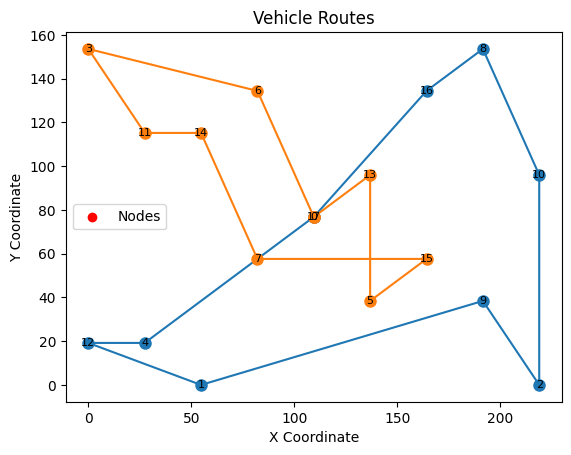

In [57]:
import matplotlib.pyplot as plt
plt.figure()
node_labels = [i for i in range(len(cx))]
for i, label in enumerate(node_labels):
    plt.text(cx[i], cy[i], str(label), fontsize=8, ha='center', va='center', color='black')
plt.scatter(cx, cy, color='red', marker='o', label='Nodes')
for route in routes:
    if len(route) == 0:
        continue
    else:
        route = transtoroute(route)
        route_x = [cx[node] for node in route]
        route_y = [cy[node] for node in route]
        plt.plot(route_x, route_y, marker='o', linestyle='-', markersize=8)
plt.title('Vehicle Routes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

